In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy import integrate, signal
import sigutils
from tqdm import tqdm
from kpfm.util import align_labels
from ffta import pixel
import pint; u = pint.UnitRegistry()
import fftrefm
reload(fftrefm)
from fftrefm import *

def Fhv_tau_to_phif(Fhv, tau, omega0, k, A):
    return (Fhv / (k*A)) * (1 + (omega0*tau)**2)**-1

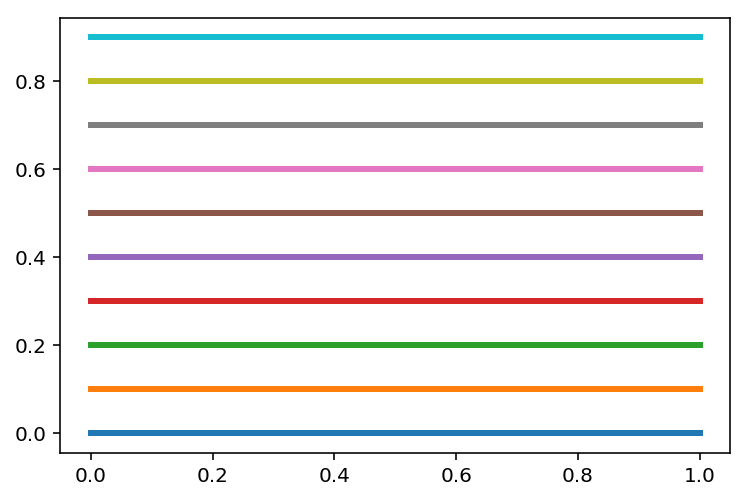

In [2]:
colors = [plt.plot([0, 1], [i*0.1, i*0.1], linewidth=3)[0].get_color() for i in xrange(10)]

In [3]:
workup_params = {'bandpass_filter': 1.0,
#               'drive_freq': 
              'filter_bandwidth': 3000.0*1e-6,
              'n_taps': 1799,
              'roi': 0.0003,
#               'sampling_rate': 10.0,
#               'total_time': e-3*1e6,
#               'trigger': 2e-3*1e6,
              'window': 'blackman',
              'wavelet_analysis': 0}

dev = 1e-4
omega_0 = 2 * np.pi *10 /19
omega_f = omega_0 * (1 - dev)
k = 72.7
Q = 499
A = 0.01 # 10 nanometer amplitude
F_d = A * k / Q
F_hv = 0
omega_d = omega_0

t0 = -2e3
dt = 1e-9 * 1e6
T = 4e3
N = int(T/dt)
t = np.arange(N) *dt + t0

# b = 6*2*np.pi*1e-3
sim_params = dict(t0=t0,
                 dt=dt,
                 T=T,
                 N=N,
                 t=t,
                 x0=np.array([0,0]),
                 fir=np.ones(1900)/1900.0,
                 dec=100)

sim_params['fir_meas'] = signal.firwin(
    workup_params['n_taps'],
    cutoff=workup_params['filter_bandwidth']/2,
    window='parzen',
    nyq=0.5 / (sim_params["dt"] * sim_params['dec'])
    )

dp1 = DDHO(omega_0=omega_0, k=k, Q=Q, omega_f=omega_f,
         omega_d=omega_d, F_d=F_d, phi_d=np.pi, tau=0.1, F_hv=-0.3e-3*k, tau_F=0.1
        )


prefactors = np.array([1, 2, 5])
scales = np.array([1e-3, 1e-2, 1e-1, 1])
taus_F = np.outer(scales, prefactors).ravel()[:10]

F_vary_tau = -0.06e-3*k
Phif_vary_tau = Fhv_tau_to_phif(F_vary_tau, taus_F, omega_0, k, A)


dps = [DDHO(omega_0=omega_0, k=k, Q=Q, omega_f=omega_f,
         omega_d=omega_d, F_d=F_d, phi_d=np.pi, tau=tau, F_hv=-0.06e-3*k, tau_F=tau
        ) for tau in taus_F]

In [4]:
trefms = [TrEFM(dp, sim_params, workup_params, ) for dp in tqdm(dps)]

  0%|          | 0/10 [00:00<?, ?it/s]fftrefm.py:136: RuntimeWarning: overflow encountered in expm1
  return np.where(t >= 0, -self.F_hv * np.expm1(-t/self.tau_F), 0)
fftrefm.py:136: RuntimeWarning: invalid value encountered in expm1
  return np.where(t >= 0, -self.F_hv * np.expm1(-t/self.tau_F), 0)
fftrefm.py:182: RuntimeWarning: overflow encountered in expm1
  (np.expm1(-gamma*t) - gamma_tau*np.expm1(-t/tau)) / (1 - gamma_tau),
fftrefm.py:182: RuntimeWarning: invalid value encountered in expm1
  (np.expm1(-gamma*t) - gamma_tau*np.expm1(-t/tau)) / (1 - gamma_tau),
fftrefm.py:210: RuntimeWarning: invalid value encountered in add
  gamma_tau * np.exp(-t/tau) - np.exp(-gamma*t))
100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


In [5]:
F_eq = -0.06e-3*k*(1 + (omega_0 * taus_F)**2)
Phif_eq = Fhv_tau_to_phif(F_eq, taus_F, omega_0, k, A)

dp_eq = [DDHO(omega_0=omega_0, k=k, Q=Q, omega_f=omega_f,
         omega_d=omega_d, F_d=F_d, phi_d=np.pi, tau=tau, F_hv=-0.06e-3*k*(1 + (omega_0 * tau)**2), tau_F=tau
        ) for tau in taus_F]

In [6]:
tr_eq = [TrEFM(dp, sim_params, workup_params, ) for dp in tqdm(dp_eq)]

100%|██████████| 10/10 [01:21<00:00,  8.12s/it]


# Fig 4 - ab

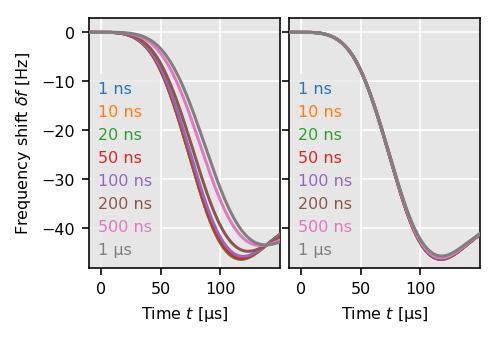

In [7]:
plt.rc('font', size=8)
fig, axes = plt.subplots(nrows=1,ncols=2,
                         subplot_kw=dict(facecolor="0.9"),
                         figsize=(3.5, 2.3), sharex=True,
                         sharey=True,)

fig.patch.set_facecolor('none')
fig.subplots_adjust(wspace=0.05)

for ax in axes:
    ax.grid(color='1')

ax0 = axes[0]
ax1 = axes[1]

i_lower = [0, 3, 4, 5, 6, 7, 8, 9]
i_upper = [0, 3, 6, 9]
lines = []
lines1 = []

for i, (trefm, tr) in enumerate(zip([trefms[i] for i in i_lower], [tr_eq[i] for i in i_lower])):
    tau = trefm.ddho.tau
    if tau < 1:
        tau_label = u"{:.0f} ns".format(tau*1000)
    elif tau > 999:
        tau_label = u"{:.0f} ms".format(tau/1000)
    else:
        tau_label = u"{:.0f} µs".format(tau)

    
    lines.append(ax0.plot(trefm.t[::100],
             scale_freq(trefm.sim_phi_meas, trefm.t[::100]),
             label=tau_label, zorder=10+i)[0])
    
    lines1.append(ax1.plot(tr.t[::100],
             scale_freq(tr.sim_phi_meas, tr.t[::100]),
             label=tau_label, zorder=10+i)[0])
    

#     ref = trefms[-1]
#     for i, trefm in zip(i_upper, [trefms[i] for i in i_upper]):
#         axr.plot(trefm('t')[::1],
#                  trefm('phase_approx_F')[::1] - ref('phase_approx_F')[::1],
#                  color=line_dict[i].get_color())




ax0.set_ylabel("Frequency shift $\\delta f$ [Hz]")
ax0.set_xlabel(u"Time $t$ [µs]")
ax1.set_xlabel(u"Time $t$ [µs]")
ax0.set_xlim(-10, 150)
ax0.set_xticks(np.arange(0, 140, 50))
ax0.set_ylim(-48, 3)
# ax0.set_xticklabels(['', '0', '50', '100', ''])




for ax in axes:
    legend = ax.legend(loc=(0.015, 0.015), handlelength=0,
                       borderaxespad=1, handletextpad=0,
                        edgecolor="0.9", facecolor="0.9")

    for line, txt in zip(legend.get_lines(), legend.get_texts()):
        txt.set_color(line.get_color())
        line.set_linewidth(0)

In [8]:
fig.savefig('../figs/Fig10ab-fftrefm-tFP.pdf', bbox_inches='tight', pad_inches=0.5,
            facecolor=fig.get_facecolor(),
            edgecolor='none')

# Fig 4 - cd

In [9]:

tau0 = 0.1

F_norms = np.linspace(0, 1, 11)
F_eq_tau = -0.06e-3*k*(1 + (omega_0 * tau0)**2)*F_norms
Phif_eq_tau = Fhv_tau_to_phif(F_eq_tau, tau0, omega_0, k, A)

taus_eq = np.ones_like(F_norms) * tau0



dp_eq_tau = [DDHO(omega_0=omega_0, k=k, Q=Q, omega_f=omega_f,
                  omega_d=omega_d, F_d=F_d, phi_d=np.pi, tau=tau0,
                  F_hv=-0.06e-3*k*(1 + (omega_0 * tau0)**2)*F_norm,
                  tau_F=tau0)
                 for F_norm in F_norms]

In [10]:
tr_eq_tau = [TrEFM(dp, sim_params, workup_params)
                   for dp in tqdm(dp_eq_tau)]

  0%|          | 0/11 [00:00<?, ?it/s]fftrefm.py:136: RuntimeWarning: invalid value encountered in multiply
  return np.where(t >= 0, -self.F_hv * np.expm1(-t/self.tau_F), 0)
fftrefm.py:209: RuntimeWarning: invalid value encountered in multiply
  phi_f - Delta_phi_F * np.exp(-t/tau) + Delta_phi_diff / (1 - gamma_tau) * (
100%|██████████| 11/11 [01:33<00:00,  8.48s/it]


In [11]:
tFPs_eq = np.array([t_FP(trefm) for trefm in tr_eq])
tFPs = np.array([t_FP(trefm) for trefm in trefms])
tFPs_eq_tau = np.array([t_FP(trefm) for trefm in tr_eq_tau])

Text(0,0.5,u'$t_\\mathrm{FP}$ [\xb5s]')

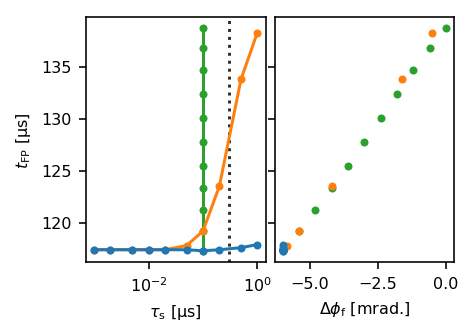

In [12]:
plt.rc('font', size=8)
fig, axess = plt.subplots(nrows=1, ncols=2,
                          subplot_kw=dict(facecolor='none'),
                          figsize=(3.3, 2.25),
                          sharey=True)

fig.patch.set_facecolor('none')
fig.subplots_adjust(wspace=0.05)


axes = axess[0]
ax1 = axess[1]

axes.axvline(1/omega_0, color='0.2', linestyle=':', zorder=2)
# axes.grid(color='1')

axes.semilogx(taus_F, tFPs_eq, '.', linestyle='-', zorder=10, label='const. $\\Delta \\phi_\\mathrm{f}$')
             
axes.semilogx(taus_F, tFPs, '.', linestyle='-', zorder=9,
              label='const. $F_{h\\nu}$')

axes.semilogx(taus_eq, tFPs_eq_tau, '.', linestyle='-',
             zorder=8, label='const. $\\tau_\\mathrm{s}$')

ax1.plot(Phif_vary_tau*1e3, tFPs, '.', zorder=9, color=colors[1])

ax1.plot(Phif_eq_tau*1e3, tFPs_eq_tau, '.',
         zorder=8,
         label='const. $\\tau_\\mathrm{s}$',
        color=colors[2])

ax1.plot(Phif_eq*1e3, tFPs_eq, '.', zorder=9, color=colors[0])


ax1.set_xlabel('$\\Delta \\phi_\\mathrm{f}$ [mrad.]')

axes.set_xlabel(u"$\\tau_\\mathrm{s}$ [µs]")
axes.set_ylabel(u"$t_\\mathrm{FP}$ [µs]")
# axes.legend(fontsize=7)

In [13]:
fig.savefig('../figs/Fig10-cd-FFtrEFM-tFP.pdf', bbox_inches='tight', pad_inches=0.5,
            facecolor=fig.get_facecolor(),
            edgecolor='none')